# 1. Import libraries and load the data

In [2510]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import haversine as hs
import folium
import branca.colormap as cm
from branca.element import Figure

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_rows', 100)

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import xgboost as xgb

In [2442]:
df_calendar = pd.read_csv("data/boston_airbnb/calendar.csv")
df_listings = pd.read_csv("data/boston_airbnb/listings.csv")

In [2443]:
df_calendar["city_assignment"] = "Boston"
df_listings["city_assignment"] = "Boston"

Short Description of the data 

* Listings: full descriptions and average review score of the Airbnb appartment
* Calendar: listing id + price / availability for that day

# 2. First Look in the data

### Check the first rows of the data

In [2444]:
df_calendar.head()

listing_id        date available price city_assignment
0    12147973  2017-09-05         f   NaN          Boston
1    12147973  2017-09-04         f   NaN          Boston
2    12147973  2017-09-03         f   NaN          Boston
3    12147973  2017-09-02         f   NaN          Boston
4    12147973  2017-09-01         f   NaN          Boston

In [2445]:
df_listings.head(3).T

0  \
id                                                                         12147973   
listing_url                                   https://www.airbnb.com/rooms/12147973   
scrape_id                                                            20160906204935   
last_scraped                                                             2016-09-07   
name                                                     Sunny Bungalow in the City   
summary                           Cozy, sunny, family home.  Master bedroom high...   
space                             The house has an open and cozy feel at the sam...   
description                       Cozy, sunny, family home.  Master bedroom high...   
experiences_offered                                                            none   
neighborhood_overview             Roslindale is quiet, convenient and friendly. ...   
notes                                                                           NaN   
transit                           The bus stop is 2 blocks away, and frequent. B...   
access                            You will have access to 2 bedrooms, a living r...   
interaction                                                                     NaN   
house_rules                       Clean up and treat the home the way you'd like...   
thumbnail_url                     https://a2.muscache.com/im/pictures/c0842db1-e...   
medium_url                        https://a2.muscache.com/im/pictures/c0842db1-e...   
picture_url                       https://a2.muscache.com/im/pictures/c0842db1-e...   
xl_picture_url                    https://a2.muscache.com/im/pictures/c0842db1-e...   
host_id                                                                    31303940   
host_url                                 https://www.airbnb.com/users/show/31303940   
host_name                                                                  Virginia   
host_since                                                               2015-04-15   
host_location                                  Boston, Massachusetts, United States   
host_about                        We are country and city connecting in our deck...   
host_response_time                                                              NaN   
host_response_rate                                                              NaN   
host_acceptance_rate                                                            NaN   
host_is_superhost                                                                 f   
host_thumbnail_url                https://a2.muscache.com/im/pictures/5936fef0-b...   
host_picture_url                  https://a2.muscache.com/im/pictures/5936fef0-b...   
host_neighbourhood                                                       Roslindale   
host_listings_count                                                               1   
host_total_listings_count                                                         1   
host_verifications                        ['email', 'phone', 'facebook', 'reviews']   
host_has_profile_pic                                                              t   
host_identity_verified                                                            f   
street                                Birch Street, Boston, MA 02131, United States   
neighbourhood                                                            Roslindale   
neighbourhood_cleansed                                                   Roslindale   
neighbourhood_group_cleansed                                                    NaN   
city                                                                         Boston   
state                                                                            MA   
zipcode                                                                       02131   
market                                                                       Boston   
smart_location                                                           Boston,

This short look into the data gives a certain insight, how the data is structured in its dataframes and strengths from the first moment the grip to the data

### Size, unique statistical units, timeframe

In [2446]:
#size
for df_name, df in zip(["df_calendar", "df_listings"], [df_calendar, df_listings]):
    print(f"The shape of {df_name} for Boston: {df[df["city_assignment"]=='Boston'].shape}")

The shape of df_calendar for Boston: (1308890, 5)
The shape of df_listings for Boston: (3585, 96)


In [2447]:
unique_flats_boston = len(df_calendar[df_calendar["city_assignment"] == "Boston"]["listing_id"].unique())

print(f"Count of appartments in Boston: {unique_flats_boston}")

Count of appartments in Boston: 3585


In [2448]:
print(f"Boston data ranges from {df_calendar[df_calendar['city_assignment'] == 'Boston']['date'].min()} to {df_calendar[df_calendar['city_assignment'] == 'Boston']['date'].max()}")

Boston data ranges from 2016-09-06 to 2017-09-05


### Null values

#### df_calendar

In [2449]:
df_calendar.isnull().sum()

listing_id              0
date                    0
available               0
price              665853
city_assignment         0
dtype: int64

In [2450]:
df_calendar["price"].isnull().value_counts(normalize = True)

price
True     0.508716
False    0.491284
Name: proportion, dtype: float64

In [2451]:
df_calendar[df_calendar.isnull().any(axis = 1)]["available"].value_counts()

available
f    665853
Name: count, dtype: int64

The calendar dataframe contains around 50 % of nan-values. The nan-values appear always when the appartment is not available (available == f).

#### df_listings

In [2452]:
null_vals_listings = pd.DataFrame(df_listings.isnull().sum().sort_values(ascending = False)).rename({0: "null_values_abs"}, axis = 1)
null_vals_listings["%"] = np.round(null_vals_listings["null_values_abs"] / df_listings.shape[0],2)

In [2453]:
null_vals_listings

null_values_abs     %
has_availability                             3585  1.00
license                                      3585  1.00
jurisdiction_names                           3585  1.00
neighbourhood_group_cleansed                 3585  1.00
square_feet                                  3529  0.98
monthly_price                                2697  0.75
weekly_price                                 2693  0.75
security_deposit                             2243  0.63
notes                                        1975  0.55
interaction                                  1554  0.43
access                                       1489  0.42
neighborhood_overview                        1415  0.39
host_about                                   1309  0.37
transit                                      1290  0.36
house_rules                                  1192  0.33
cleaning_fee                                 1107  0.31
space                                        1057  0.29
review_scores_accuracy                        823  0.23
review_scores_location                        822  0.23
review_scores_value                           821  0.23
review_scores_checkin                         820  0.23
review_scores_cleanliness                     818  0.23
review_scores_communication                   818  0.23
review_scores_rating                          813  0.23
last_review                                   756  0.21
reviews_per_month                             756  0.21
first_review                                  756  0.21
medium_url                                    599  0.17
thumbnail_url                                 599  0.17
xl_picture_url                                599  0.17
neighbourhood                                 543  0.15
host_response_time                            471  0.13
host_acceptance_rate                          471  0.13
host_response_rate                            471  0.13
host_neighbourhood                            339  0.09
summary                                       143  0.04
zipcode                                        38  0.01
market                                         14  0.00
bathrooms                                      14  0.00
host_location                                  11  0.00
bedrooms                                       10  0.00
beds                                            9  0.00
property_type                                   3  0.00
city                                            2  0.00
scrape_id                                       0  0.00
id                                              0  0.00
experiences_offered                             0  0.00
last_scraped                                    0  0.00
host_picture_url                                0  0.00
host_thumbnail_url                              0  0.00
host_is_superhost                               0  0.00
picture_url                                     0  0.00
host_id                                         0  0.00
host_url                                        0  0.00
host_name                                       0  0.00
host_since                                      0  0.00
listing_url                                     0  0.00
name                                            0  0.00
description                                     0  0.00
country_code                                    0  0.00
country                                         0  0.00
host_listings_count                             0  0.00
host_verifications                              0  0.00
host_total_listings_count                       0  0.00
price                                           0  0.00
amenities                                       0  0.00
bed_type                                        0  0.00
latitude                                        0  0.00
is_location_exact                               0  0.00
longitude                                       0  0.00
accommodates                                    0  0.00
ro

There are several attributes in df_listings which show high values of null values.<br>
For example, the columns "has_availability", "licence", "jurisdiction_names", "neighbourhood_group_cleansed" or "square_feet" are missing to a high degree (98 % - 100 %) and contain no information for further analysis.<br>
The other columns with higher proportions of missing values should be investigated within the further analysis


### Check one appartment

For deeper understandment of the data, it is helpful to look into one record to grasph the idea of the columns.

In [2454]:
df_one_airbnb = df_listings[df_listings["id"] == 12147973]

for col in df_one_airbnb.columns:
    print(f"{col}: {df_one_airbnb[col].values[0]}")

id: 12147973
listing_url: https://www.airbnb.com/rooms/12147973
scrape_id: 20160906204935
last_scraped: 2016-09-07
name: Sunny Bungalow in the City
summary: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.
space: The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.
description: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives &

### Check the datatypes

#### df_calendar

In [2455]:
df_calendar.dtypes

listing_id          int64
date               object
available          object
price              object
city_assignment    object
dtype: object

* date column should be transformed to date / datetime
* price should be transformed in float

#### df_listings

In [2456]:
df_listings.dtypes.value_counts()

object     63
float64    18
int64      15
Name: count, dtype: int64

In [2457]:
df_listings.columns[df_listings.dtypes == "object"]

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_rev

In [2458]:
df_listings[df_listings.columns[df_listings.dtypes == "object"]].head(1).T

0
listing_url                                   https://www.airbnb.com/rooms/12147973
last_scraped                                                             2016-09-07
name                                                     Sunny Bungalow in the City
summary                           Cozy, sunny, family home.  Master bedroom high...
space                             The house has an open and cozy feel at the sam...
description                       Cozy, sunny, family home.  Master bedroom high...
experiences_offered                                                            none
neighborhood_overview             Roslindale is quiet, convenient and friendly. ...
notes                                                                           NaN
transit                           The bus stop is 2 blocks away, and frequent. B...
access                            You will have access to 2 bedrooms, a living r...
interaction                                                                     NaN
house_rules                       Clean up and treat the home the way you'd like...
thumbnail_url                     https://a2.muscache.com/im/pictures/c0842db1-e...
medium_url                        https://a2.muscache.com/im/pictures/c0842db1-e...
picture_url                       https://a2.muscache.com/im/pictures/c0842db1-e...
xl_picture_url                    https://a2.muscache.com/im/pictures/c0842db1-e...
host_url                                 https://www.airbnb.com/users/show/31303940
host_name                                                                  Virginia
host_since                                                               2015-04-15
host_location                                  Boston, Massachusetts, United States
host_about                        We are country and city connecting in our deck...
host_response_time                                                              NaN
host_response_rate                                                              NaN
host_acceptance_rate                                                            NaN
host_is_superhost                                                                 f
host_thumbnail_url                https://a2.muscache.com/im/pictures/5936fef0-b...
host_picture_url                  https://a2.muscache.com/im/pictures/5936fef0-b...
host_neighbourhood                                                       Roslindale
host_verifications                        ['email', 'phone', 'facebook', 'reviews']
host_has_profile_pic                                                              t
host_identity_verified                                                            f
street                                Birch Street, Boston, MA 02131, United States
neighbourhood                                                            Roslindale
neighbourhood_cleansed                                                   Roslindale
city                                                                         Boston
state                                                                            MA
zipcode                                                                       02131
market                                                                       Boston
smart_location                                                           Boston, MA
country_code                                                                     US
country                                                               United States
is_location_exact                                                                 t
property_type                                                                 House
room_type                                                           Entire home/apt
bed_type                                                                   Real Bed
amenities                         {TV,"Wireless Internet",Kitchen,"Free Parking ...
price                                             

In [2459]:
df_listings.columns[df_listings.dtypes == "float64"]

Index(['neighbourhood_group_cleansed', 'latitude', 'longitude', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'has_availability',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'reviews_per_month'],
      dtype='object')

In [2460]:
df_listings.columns[df_listings.dtypes == "int64"]

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'calculated_host_listings_count'],
      dtype='object')

There are some of the attributes classified as "object" which are in reality numerical or date. In the following, the necessary variables will be transformed

### Check nunique values

#### df_calendar

In [2461]:
df_calendar.nunique()

listing_id         3585
date                365
available             2
price              1246
city_assignment       1
dtype: int64

#### df_listings

In [2462]:
df_listings.nunique().sort_values(ascending = True)

neighbourhood_group_cleansed           0
jurisdiction_names                     0
license                                0
has_availability                       0
country_code                           1
last_scraped                           1
experiences_offered                    1
scrape_id                              1
calendar_last_scraped                  1
state                                  1
city_assignment                        1
requires_license                       1
country                                1
is_location_exact                      2
host_identity_verified                 2
host_is_superhost                      2
instant_bookable                       2
require_guest_profile_picture          2
host_has_profile_pic                   2
require_guest_phone_verification       2
room_type                              3
host_response_time                     4
cancellation_policy                    4
market                                 4
bed_type        

The attributes with nunique vals = 1 are not informative for a model and can be dropped in the following

# 3. First Preprocessing

#### drop attributes without any information

In [2463]:
null_attributes = null_vals_listings.loc[null_vals_listings["%"] == 1].index.tolist()
nunique_attributes = df_listings.nunique().sort_values(ascending = True).loc[df_listings.nunique().sort_values(ascending = True)<=1].index.tolist()

df_listings_dropped = df_listings.drop(null_attributes + nunique_attributes, axis = 1)

#### Add the attribute "distance to city center"

In [2464]:
city_center_boston_lat = 42.361145
city_center_boston_lon = -71.057083
boston_loc = (city_center_boston_lat, city_center_boston_lon)

df_listings["distance_to_city_center"] = df_listings_dropped.apply(lambda x: hs.haversine(boston_loc, (x["latitude"], x["longitude"])), axis = 1)

# 4. Analysis

Question Beschreibung
########
########
########
########
########

## A. Amenities

In [2465]:
amenities_dict = {}

for id in df_listings["id"]: 

    amenities = df_listings[df_listings["id"] == id]["amenities"].replace(r"[{}\"]", "", regex = True).str.split(",").iloc[0]
    amenities_dict[id] = amenities

In [2466]:
list_amenities = sorted(list(set(",".join([",".join(l) for l in list(amenities_dict.values())]).split(","))))[1:]
df_amenities = pd.DataFrame({"Amenities": list_amenities})

In [2467]:
for listing_id in list(amenities_dict.keys()):

    df_amenities[listing_id] = [1 if amenit in amenities_dict[listing_id] else 0 for amenit in df_amenities["Amenities"]]

In [2468]:
df_amenities = df_amenities.set_index("Amenities").T

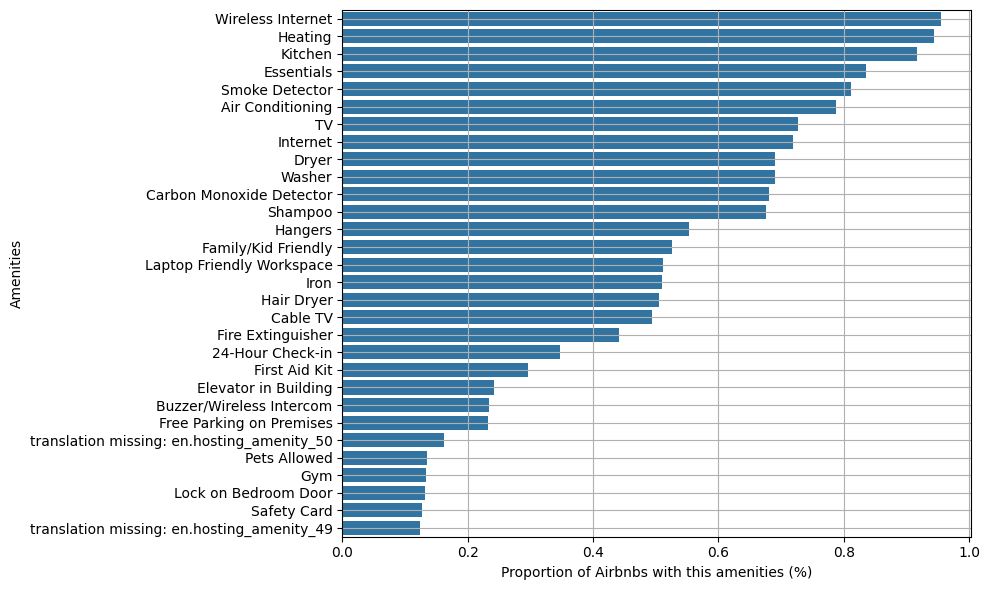

In [2469]:
fig,sub = plt.subplots(1,1,figsize=(10,6))

top_thirty_amenities = df_amenities.mean(axis=0).sort_values(ascending = False).head(30)

sns.barplot(
    y = top_thirty_amenities.index,
    x = top_thirty_amenities,
    ax = sub,
    orient = "h"
)

sub.grid()
sub.set_xlabel("Proportion of Airbnbs with this amenities (%)")

fig.tight_layout()

## B. 

Define the relevant features + merge them with the amenities

In [2511]:
relevant_feats = ["id", "host_response_time", "host_is_superhost", "host_listings_count", "host_total_listings_count", "host_verifications",
"host_has_profile_pic", "host_identity_verified", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "price", "cleaning_fee",
"guests_included", "extra_people", "minimum_nights", "maximum_nights", "availability_30", "availability_60", "availability_90", "availability_365", "number_of_reviews", "review_scores_rating",
"review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "cancellation_policy", "distance_to_city_center", "security_deposit", 'latitude',
"longitude", "first_review", "last_review", "calculated_host_listings_count", "require_guest_profile_picture", "require_guest_phone_verification", "reviews_per_month"]

#, "city","host_acceptance_rate""host_response_rate","property_type","neighbourhood_cleansed"

df_listings = df_listings[relevant_feats]

In [2512]:
df_listings_relevant = pd.merge(
    left = df_listings,
    right = df_amenities,
    left_on= "id",
    right_index=True,
    how = "left"
)

df_listings_relevant.drop("id", axis = 1, inplace = True)

Execute general Cleaning steps

In [2513]:
def clean_prices(df_): 

    df_ = df_.str.replace("[,$]", "", regex=True).copy()
    df_ = df_.astype("float")
    df_.rename("price_in_dollar", inplace = True)

    return df_

In [2514]:
for col in ["price", "cleaning_fee", "extra_people", "security_deposit"]:
    df_listings_relevant[col] = clean_prices(df_listings_relevant[col])

In [2515]:
df_listings_relevant["cnt_of_host_verif"] = df_listings_relevant["host_verifications"].str[:].apply(lambda x: len(x.replace("[", "").replace("]","").split(",")))
df_listings_relevant.drop("host_verifications", axis = 1, inplace = True)

In [2516]:
experience = df_listings_relevant[["first_review","last_review"]].fillna("2024-01-01")
experience["first_review"] = pd.to_datetime(experience["first_review"], format = "%Y-%m-%d")
experience["last_review"] = pd.to_datetime(experience["last_review"], format = "%Y-%m-%d")

experience["experience"] = (experience["last_review"] - experience["first_review"]).dt.days

In [2517]:
df_listings_relevant["experience_in_years"] = experience["experience"].copy()
df_listings_relevant.drop(["first_review", "last_review"], axis = 1, inplace = True)

Split validation data and training / test data

In [2518]:
validation_data = df_listings_relevant.sample(int(df_listings_relevant.shape[0] * 0.1))
df_listing_relevant_train = df_listings_relevant.drop(index= validation_data.index.tolist())

Define transformation function

a) General transformations

In [2519]:
def get_data_to_impute(df_):

    return df_.isnull().sum()[(df_.isnull().sum()>0)].sort_values(ascending = False) / df_.shape[0]

In [2520]:
get_data_to_impute(df_listing_relevant_train)

security_deposit               0.627828
cleaning_fee                   0.307096
review_scores_accuracy         0.225906
review_scores_location         0.224977
review_scores_checkin          0.224977
review_scores_value            0.224977
review_scores_communication    0.224357
review_scores_cleanliness      0.224357
review_scores_rating           0.222808
reviews_per_month              0.207623
host_response_time             0.131081
bathrooms                      0.003719
bedrooms                       0.003099
beds                           0.002479
dtype: float64

In [2521]:
get_data_to_impute(validation_data)

security_deposit               0.606145
cleaning_fee                   0.324022
review_scores_location         0.268156
review_scores_value            0.265363
review_scores_rating           0.262570
review_scores_communication    0.262570
review_scores_checkin          0.262570
review_scores_cleanliness      0.262570
review_scores_accuracy         0.262570
reviews_per_month              0.240223
host_response_time             0.134078
bathrooms                      0.005587
beds                           0.002793
dtype: float64

In [2522]:
df_listing_relevant_train["security_deposit"].fillna(0, inplace = True)
df_listing_relevant_train["cleaning_fee"].fillna(0, inplace = True)

validation_data["security_deposit"].fillna(0, inplace = True)
validation_data["cleaning_fee"].fillna(0, inplace = True)

In [2523]:
get_data_to_impute(df_listing_relevant_train)

review_scores_accuracy         0.225906
review_scores_location         0.224977
review_scores_checkin          0.224977
review_scores_value            0.224977
review_scores_communication    0.224357
review_scores_cleanliness      0.224357
review_scores_rating           0.222808
reviews_per_month              0.207623
host_response_time             0.131081
bathrooms                      0.003719
bedrooms                       0.003099
beds                           0.002479
dtype: float64

In [2524]:
get_data_to_impute(validation_data)

review_scores_location         0.268156
review_scores_value            0.265363
review_scores_rating           0.262570
review_scores_checkin          0.262570
review_scores_cleanliness      0.262570
review_scores_communication    0.262570
review_scores_accuracy         0.262570
reviews_per_month              0.240223
host_response_time             0.134078
bathrooms                      0.005587
beds                           0.002793
dtype: float64

b) Define imputation for cv runs to prevent leakage

In [2525]:
def impute_vals(df_train, df_test):

    if df_train is None: 
        if df_test.dtypes == "object":
            df_test.fillna(df_test.mode()[0],inplace = True)
        else:
            df_test.fillna(df_test.mean(), inplace = True)
    else:
        if df_train.dtypes == "object":
            df_train.fillna(df_train.mode()[0], inplace = True)
            df_test.fillna(df_train.mode()[0], inplace = True)
        else:
            df_train.fillna(df_train.median(), inplace = True)
            df_test.fillna(df_train.median(), inplace = True)

    return df_train, df_test

Prepare data for prediction

In [2526]:
def tuckey_method(df_):

    Q1 = df_.quantile(0.25)
    Q3 = df_.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = df_[(df_ < (Q1 - 1.5 * IQR)) | (df_> (Q3 + 1.5 * IQR))]
                      
    return outliers_iqr

Check for outliers

In [2527]:
tuckey_method(df_listing_relevant_train["price"]).sort_values(ascending=False)

2285    4000.0
793     1400.0
1950    1345.0
1022    1300.0
2448    1275.0
         ...  
659      425.0
1273     425.0
1832     425.0
2112     425.0
2148     425.0
Name: price, Length: 110, dtype: float64

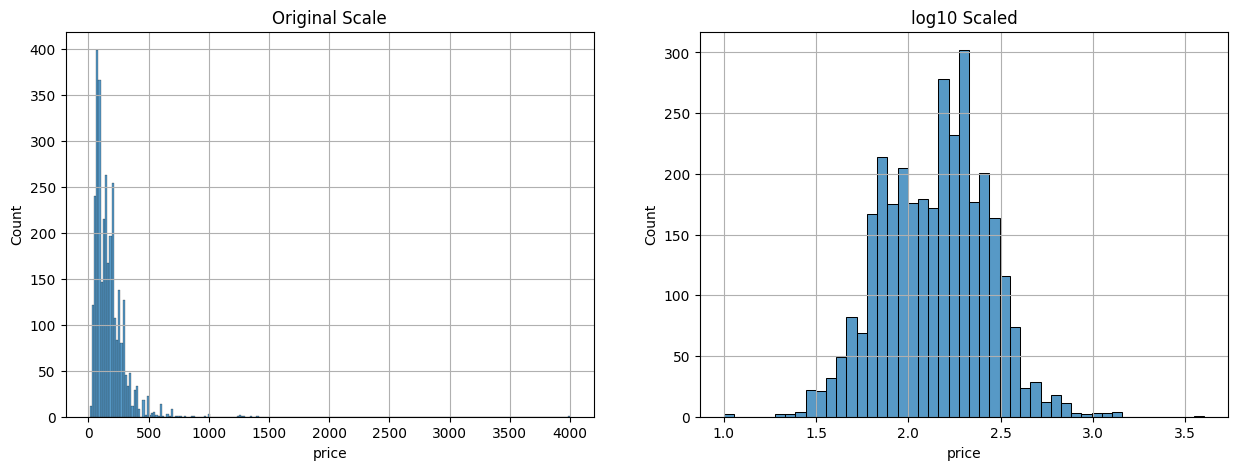

In [2528]:
fig, sub = plt.subplots(1,2, figsize = (15,5))

sns.histplot(x = df_listing_relevant_train["price"], ax = sub[0])
sns.histplot(x = np.log10(df_listing_relevant_train["price"]), ax = sub[1])

for name, s in zip(["Original Scale", "log10 Scaled"],sub.flatten()):
    s.grid()

    s.set_title(f"{name}")

In [2529]:
X_ = df_listing_relevant_train.drop("price", axis = 1)
y_ = df_listing_relevant_train["price"]

X_valid = validation_data.drop("price", axis = 1)
y_valid = validation_data["price"]

In [2530]:
cols_binary = ["instant_bookable", "host_is_superhost", "host_has_profile_pic", "host_identity_verified", "require_guest_phone_verification", "require_guest_profile_picture"]

In [2531]:
for col in cols_binary:
    X_[col] = X_[col].map({"f": 0, "t": 1})
    X_valid[col] = X_valid[col].map({"f": 0, "t": 1}) 

In [2532]:
X_num = X_[X_.columns[X_.dtypes != "object"].tolist()]
X_cat = X_[X_.columns[X_.dtypes == "object"].tolist()]

X_num_valid = X_valid[X_valid.columns[X_valid.dtypes != "object"].tolist()]
X_cat_valid = X_valid[X_valid.columns[X_valid.dtypes == "object"].tolist()]

In [2533]:
X_ = pd.concat([X_num, pd.get_dummies(data = X_cat, prefix_sep = "_", drop_first=True)], axis = 1)
X_valid = pd.concat([X_num_valid, pd.get_dummies(data = X_cat_valid, prefix_sep = "_", drop_first=True)], axis = 1)

Ridge Regression

Crossvalidation Approach

In [2534]:
def crossvalidate_model(X_, y_, model, k_fold):

    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=42) 

    test_score_r2 = []
    test_score_rmse = []
    test_score_mae = []

    for k, (train_index,test_index) in enumerate(kfold.split(X_)):
        
        X_train, X_test, y_train, y_test = X_.iloc[train_index], X_.iloc[test_index], y_.iloc[train_index], y_.iloc[test_index]


        cols_to_impute = get_data_to_impute(X_).index

        for col in cols_to_impute:

            X_train[col], X_test[col] = impute_vals(X_train[col], X_test[col])

        #Scaling        
        y_train_log = np.log10(y_train)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Model
        model.fit(X_train_scaled, y_train_log)

        y_test_preds = model.predict(X_test_scaled)
        y_test_preds = 10**y_test_preds

        test_score_r2_ = r2_score(y_test, y_test_preds)
        test_score_rmse_ = root_mean_squared_error(y_test, y_test_preds)
        test_score_mae_ = mean_absolute_error(y_test, y_test_preds)

        #print scores
        print(f"\n############ Fold {k+1} ############")
        for score_name, score in zip(["r2 Score", "rmse", "mae"], [test_score_r2_, test_score_rmse_, test_score_mae_]):
            print(f"{score_name}: {score}")

        test_score_r2.append(np.round(test_score_r2_,2))
        test_score_rmse.append(np.round(test_score_rmse_,2))
        test_score_mae.append(np.round(test_score_mae_,2))

    return [test_score_r2, test_score_rmse, test_score_mae]

In [2537]:
###################
params = {"alpha": 1.0, "fit_intercept": True, "random_state":42}
model_ridge = Ridge(**params)
r2_ls, rmse_ls, mae_ls = crossvalidate_model(X_, y_, model_ridge, k_fold=10)


############ Fold 1 ############
r2 Score: 0.4440002737224823
rmse: 105.07218779866122
mae: 42.833699022352384

############ Fold 2 ############
r2 Score: 0.6213832696191051
rmse: 62.95426248952161
mae: 41.21478273553651

############ Fold 3 ############
r2 Score: 0.4232007865218057
rmse: 111.05796268875415
mae: 48.59740487251217

############ Fold 4 ############
r2 Score: 0.12775314714466468
rmse: 222.64085929099545
mae: 56.23315263127552

############ Fold 5 ############
r2 Score: 0.5542828376169191
rmse: 76.30861405007727
mae: 44.11075651004341

############ Fold 6 ############
r2 Score: 0.6660200515635077
rmse: 77.83805087448117
mae: 44.83451867632731

############ Fold 7 ############
r2 Score: 0.5937523348757245
rmse: 67.4062860652666
mae: 42.176317740208226

############ Fold 8 ############
r2 Score: 0.23797465747663127
rmse: 109.30605123792989
mae: 50.08617827082872

############ Fold 9 ############
r2 Score: 0.48637715130236026
rmse: 86.77012719667428
mae: 46.95479040798417

#

In [2538]:
print(f"Mean r2: {np.mean(r2_ls)}")
print(f"Mean rmse: {np.mean(rmse_ls)}")
print(f"Mean mae: {np.mean(mae_ls)}")

Mean r2: 0.4710000000000001
Mean rmse: 101.27799999999999
Mean mae: 46.614000000000004


Train Test Split 

In [2539]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

cols_to_impute = get_data_to_impute(X_).index

for col in cols_to_impute:

    X_train[col], X_test[col] = impute_vals(X_train[col], X_test[col])

#Scaling        
y_train_log = np.log10(y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2540]:
params = {"alpha": 1.0, "fit_intercept": True, "random_state":42}
model_ridge = Ridge(**params)

model_ridge.fit(X_train_scaled, y_train_log)

Ridge(random_state=42)

In [2541]:
y_test_pred = model_ridge.predict(X_test_scaled)
y_test_pred = 10 ** y_test_pred

test_score_r2_ = r2_score(y_test, y_test_pred)
test_score_rmse_ = root_mean_squared_error(y_test, y_test_pred)
test_score_mae_ = mean_absolute_error(y_test, y_test_pred)

for score_name, score in zip(["r2 Score", "rmse", "mae"], [test_score_r2_, test_score_rmse_, test_score_mae_]):
    print(f"{score_name}: {score}")

r2 Score: 0.5002042096229836
rmse: 87.05194245223416
mae: 42.10490272826117


In [2542]:
params = {"alpha": 1.0, "fit_intercept": True, "random_state":42}
model_ridge = Ridge(**params)


cols_to_impute = get_data_to_impute(X_).index

for col in cols_to_impute:
    X_[col], X_valid[col] = impute_vals(X_[col], X_valid[col])

y_train_log = np.log10(y_)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_)
X_valid_scaled = scaler.transform(X_valid)

model_ridge.fit(X_train_scaled, y_train_log)
y_valid_preds = model_ridge.predict(X_valid_scaled)
y_valid_preds = 10**y_valid_preds

test_score_r2_ = r2_score(y_valid, y_valid_preds)
test_score_rmse_ = root_mean_squared_error(y_valid, y_valid_preds)
test_score_mae_ = mean_absolute_error(y_valid, y_valid_preds)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- bed_type_Couch


In [2363]:
test_score_r2_

0.21077078927276216

In [2364]:
reg_coefs = pd.DataFrame()
reg_coefs["predictors"] = X_.columns
reg_coefs["coefs"] = 10 ** model_ridge.coef_ 

In [2365]:
reg_coefs.sort_values(by = "coefs", ascending=False)

predictors     coefs
4                          accommodates  1.110839
2                              bedrooms  1.107972
12                     Air Conditioning  1.065269
9                                    TV  1.056342
16     require_guest_phone_verification  1.053081
24  cancellation_policy_super_strict_30  1.033016
10                               Washer  1.026715
3                             bathrooms  1.025083
8                      security_deposit  1.024263
5                     host_is_superhost  1.023804
13                         extra_people  1.016040
11                       Washer / Dryer  1.007382
15               host_identity_verified  1.007102
22         cancellation_policy_moderate  1.003962
14                 host_has_profile_pic  1.003109
0                          cleaning_fee  1.002743
1                                  beds  1.001261
17        require_guest_profile_picture  0.991045
23           cancellation_policy_strict  0.988302
19                  experience_in_years  0.982109
18                    cnt_of_host_verif  0.974239
6                      instant_bookable  0.967817
21                room_type_Shared room  0.899835
7               distance_to_city_center  0.837718
20               room_type_Private room  0.790939

# 3. Establish Questions

1) Is the price in general higher in the city center?
2) Is the distance to the city center a determining factor for the prices? 
3) Is there a time within a year, where the prices are higher / lower? 
4) Are the prices of appartments which are not highly booked lower?

In [742]:
potential_feats = ["weekday", "host_is_superhost", "host_reponse_rate", "host_response_time", 
"distance_to_city_center", "property_type", "accomodates", "bathrooms", "bedrooms", "beds", "square_feet", "security_deposit", "review_scores_rating"]

# 4. Preprocessing

## A. Clean the data

In [743]:
df_calendar["price"] = df_calendar["price"].str.replace("[,$]", "", regex=True).copy()
df_calendar["price"] = df_calendar["price"].astype("float")
df_calendar.rename({"price": "price_in_dollar"}, axis = 1, inplace = True)

df_listings["price"] = df_listings["price"].str.replace("[,$]", "", regex=True).copy()
df_listings["price"] = df_listings["price"].astype("float")
df_listings.rename({"price": "price_in_dollar"}, axis = 1, inplace = True)

df_calendar["date"] = pd.to_datetime(df_calendar["date"], format = "%Y-%m-%d")

## A. Handling Missing Data

### Check which data's is missing

In [744]:
df_boston_c = df_calendar[df_calendar["city_assignment"] == "Boston"]
df_seattle_c = df_calendar[df_calendar["city_assignment"] == "Seattle"]

In [745]:
#drop appartments which hasn't been rented in the observation time frame
def get_not_relevant_listings(df):

    not_available_ranking = df.groupby("listing_id")["available"].value_counts(normalize=True).reset_index().query("available == 'f'").sort_values(by = "proportion", ascending=False)
    not_relevant_listings = not_available_ranking[not_available_ranking["proportion"] == 1.0]["listing_id"].unique().tolist()

    return not_relevant_listings
######################

not_relevant_boston = get_not_relevant_listings(df_boston_c)
not_relevant_seattle = get_not_relevant_listings(df_seattle_c)

mask_boston = (df_calendar["city_assignment"] == "Boston")&(df_calendar["listing_id"].isin(not_relevant_boston))
mask_seattle= (df_calendar["city_assignment"] == "Seattle")&(df_calendar["listing_id"].isin(not_relevant_seattle))

df_calendar_dropped = df_calendar[(~mask_boston)&(~mask_seattle)]

In [746]:
#impute the price by forward and backward filling
df_calendar_dropped = df_calendar_dropped.sort_values(by = ["listing_id", "date"], ascending=True)
df_calendar_dropped.loc[:, "price_in_dollar_ff"] = df_calendar_dropped.groupby("listing_id")["price_in_dollar"].transform(lambda v: v.ffill().bfill())

In [747]:
df_calendar_dropped

listing_id       date available  price_in_dollar city_assignment  \
1207784        3353 2016-09-06         f              NaN          Boston   
1207783        3353 2016-09-07         f              NaN          Boston   
1207782        3353 2016-09-08         f              NaN          Boston   
1207781        3353 2016-09-09         f              NaN          Boston   
1207780        3353 2016-09-10         f              NaN          Boston   
...             ...        ...       ...              ...             ...   
388364     14933461 2017-09-01         t            165.0          Boston   
388363     14933461 2017-09-02         t            165.0          Boston   
388362     14933461 2017-09-03         t            165.0          Boston   
388361     14933461 2017-09-04         t            165.0          Boston   
388360     14933461 2017-09-05         t            165.0          Boston   

         price_in_dollar_ff  
1207784                32.0  
1207783                32.0  
1207782                32.0  
1207781                32.0  
1207780                32.0  
...                     ...  
388364                165.0  
388363                165.0  
388362                165.0  
388361                165.0  
388360                165.0  

[1061055 rows x 6 columns]

## B. Handle categorical data

# 5. Analysis

### A. Is the price in general higher in the city center?

#### Preparation of general data

In [748]:
city_center_seattle_lat = 47.60621 
city_center_seattle_lon = -122.33207
seattle_loc = (city_center_seattle_lat, city_center_seattle_lon)

city_center_boston_lat = 42.361145
city_center_boston_lon = -71.057083
boston_loc = (city_center_boston_lat, city_center_boston_lon)

In [749]:
#calc distances to city center
df_listings["distance_to_city_center"] = df_listings.apply(lambda x: hs.haversine(boston_loc, (x["latitude"], x["longitude"])) if x["city_assignment"]=="Boston" else  hs.haversine(seattle_loc, (x["latitude"], x["longitude"])), axis = 1)

In [750]:
def draw_map(df, loc_city_center):

    fig = Figure(width=1200, height=600)

    min_price = df["price_in_dollar"].astype("float").min()
    median_price = df["price_in_dollar"].astype("float").median()
    std_price = df["price_in_dollar"].astype("float").std()
    max_price = df["price_in_dollar"].astype("float").max()

    map = folium.Map(location=[loc_city_center[0], loc_city_center[1]], zoom_start=12, width=1200, height=600)
    fig.add_child(map)

    folium.TileLayer('cartodbpositron').add_to(map)

    colormap = cm.StepColormap(colors=['green','yellow', 'orange', 'red'] ,
                            #index=[min_price, 100, 250,1000], 
                            vmin= min_price,
                            vmax=median_price + 1.5 * std_price)

    for id in df["id"].unique():

        lat = df[df["id"] == id]["latitude"]
        lon = df[df["id"] == id]["longitude"]
        price = df[df["id"] == id]["price_in_dollar"].astype("float").values[0]
        name = df[df["id"] == id]["name"].values[0]

        folium.Circle(
            location = [lat, lon],
            radius=6,
            fill=True,
            popup=f"name: {name}\nprice: {price} Dollar",
            color=colormap(price)
            ).add_to(map)


    folium.Marker(
        location = [loc_city_center[0], loc_city_center[1]],
        popup = "City Center"
    ).add_to(map)

    display(fig)

In [751]:
df_listing_boston = df_listings[df_listings["city_assignment"] == "Boston"]
df_listing_seattle = df_listings[df_listings["city_assignment"] == "Seattle"]

#### Visual Check of Maps concerning Airbnb prices

Boston

In [752]:
draw_map(df_listing_boston, boston_loc)

Seattle

In [753]:
draw_map(df_listing_seattle, seattle_loc)

Observations -------------------------------

#### Correlation Analysis

In [754]:
feats = ["distance_to_city_center", "price_in_dollar"]

df_listing_seattle[feats].corr()

distance_to_city_center  price_in_dollar
distance_to_city_center                      NaN              NaN
price_in_dollar                              NaN              NaN

In [755]:
feats = ["distance_to_city_center", "price_in_dollar"]

df_listing_boston[feats].corr()

distance_to_city_center  price_in_dollar
distance_to_city_center                 1.000000        -0.296221
price_in_dollar                        -0.296221         1.000000

In [756]:
feats = ["distance_to_city_center", "price_in_dollar"]

df_listings[feats].corr()

distance_to_city_center  price_in_dollar
distance_to_city_center                 1.000000        -0.296221
price_in_dollar                        -0.296221         1.000000

-------------------Observations

### B. Is there a concrete period in the year, where prices variate with time?

In [757]:
df_calendar_boston = df_calendar_dropped[df_calendar_dropped["city_assignment"] == "Boston"]
df_calendar_seattle = df_calendar_dropped[df_calendar_dropped["city_assignment"] == "Seattle"]

In [758]:
df_calendar_boston_mean = df_calendar_boston.groupby("date")["price_in_dollar"].mean()
df_calendar_seattle_mean = df_calendar_seattle.groupby("date")["price_in_dollar"].mean()
df_calendar_mean = df_calendar_dropped.groupby("date")["price_in_dollar"].mean()

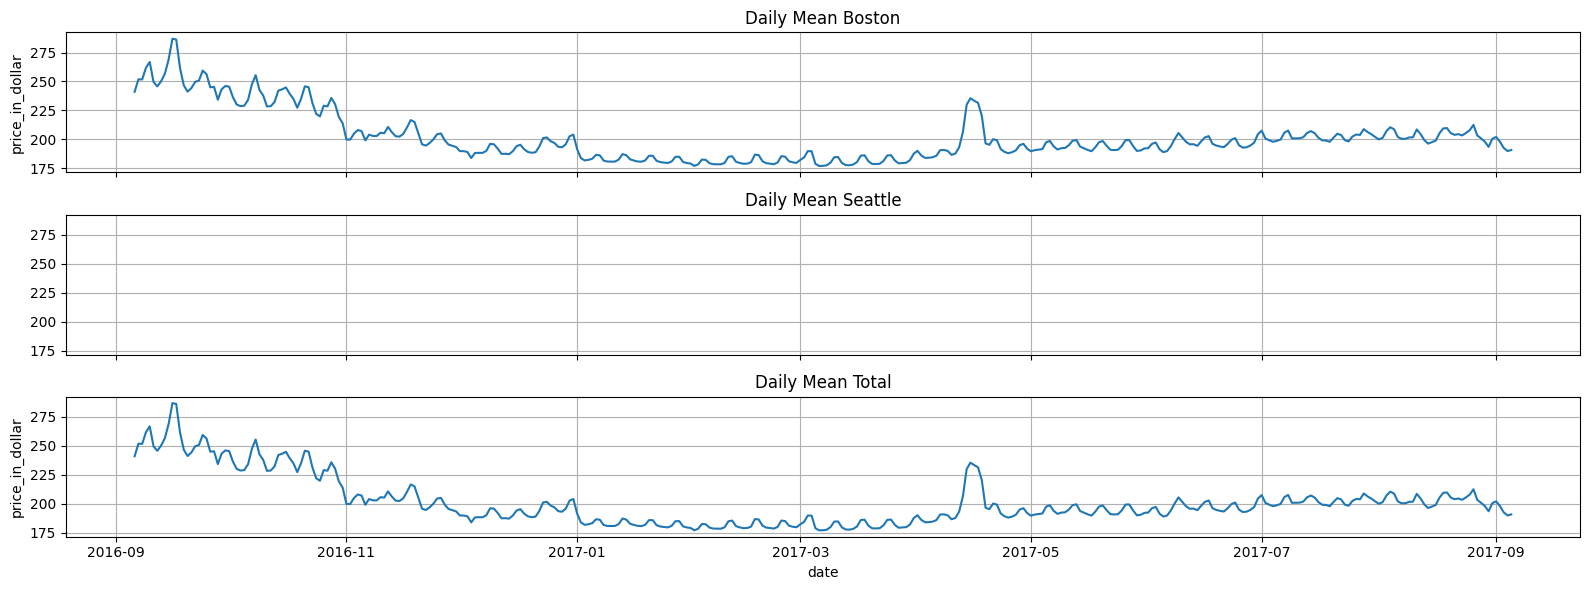

In [759]:
fig, sub = plt.subplots(3,1,figsize=(16,6), sharex=True, sharey=True)
sub = sub.flatten()

sns.lineplot(x = df_calendar_boston_mean.index, y = df_calendar_boston_mean, ax = sub[0])
sns.lineplot(x = df_calendar_seattle_mean.index, y = df_calendar_seattle_mean, ax = sub[1])
sns.lineplot(x = df_calendar_mean.index, y = df_calendar_mean, ax = sub[2])

ls = ["Daily Mean Boston",  "Daily Mean Seattle", "Daily Mean Total"]

for i,s in enumerate(sub.flatten()):
    s.grid()
    s.set_title(ls[i])

fig.tight_layout()

Text(0.5, 1.0, 'Seattle Airbnb Daily Mean Price over weekdays')

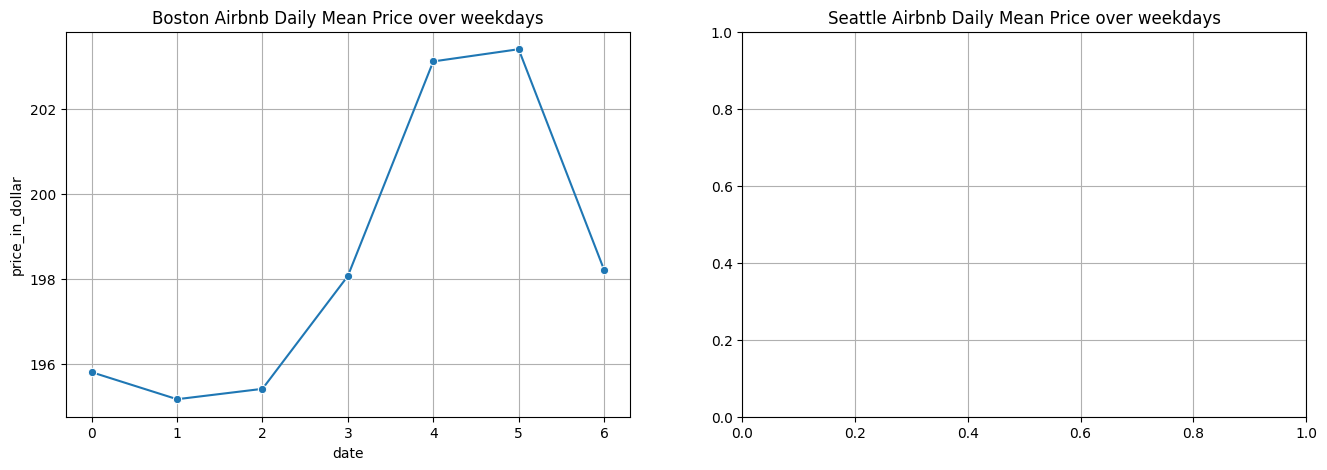

In [760]:
fig, sub = plt.subplots(1,2, figsize=(16,5))

boston_day_of_week = df_calendar_boston.groupby(df_calendar_boston["date"].dt.dayofweek)["price_in_dollar"].mean()
seattle_day_of_week = df_calendar_seattle.groupby(df_calendar_seattle["date"].dt.dayofweek)["price_in_dollar"].mean()

sns.lineplot(x = boston_day_of_week.index, y = boston_day_of_week, ax = sub[0], marker = "o")
sns.lineplot(x = seattle_day_of_week.index, y = seattle_day_of_week, ax = sub[1], marker = "o")

sub[0].grid()
sub[1].grid()

sub[0].set_title("Boston Airbnb Daily Mean Price over weekdays")
sub[1].set_title("Seattle Airbnb Daily Mean Price over weekdays")

### C. Is the distance to the city center a determining factor for the prices?

In [761]:
potential_feats = ["weekday", "host_is_superhost", "host_reponse_rate", "host_response_time", 
"zipcode", "distance_to_city_center", "property_type", "accomodates", "bathrooms", "bedrooms", "beds", "square_feet", "security_deposit", "review_scores_rating"]

In [762]:
df_calendar_dropped.head(3)

listing_id       date available  price_in_dollar city_assignment  \
1207784        3353 2016-09-06         f              NaN          Boston   
1207783        3353 2016-09-07         f              NaN          Boston   
1207782        3353 2016-09-08         f              NaN          Boston   

         price_in_dollar_ff  
1207784                32.0  
1207783                32.0  
1207782                32.0

In [763]:
df_calendar_dropped["weekday"] = df_calendar_dropped["date"].dt.weekday

In [764]:
pd.merge(left = df_calendar_dropped, )

TypeError: merge() missing 1 required positional argument: 'right'

# 6. Conclusion